In [1]:
#IMPORTS
import praw
import urllib.request
import xmltodict   
from datetime import datetime

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import string
import numpy as np
import matplotlib.pyplot as plt
from gensim.summarization.summarizer import summarize


#import interface
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
from matplotlib.figure import Figure


# PARTIE 1

In [2]:
#classe pour gérer chaque publication document (récupérée des TD)
class Document():    
    # constructeur
    def __init__(self, date, title, author, text, url):
        self.date = date
        self.title = title
        self.author = author
        self.text = text
        self.url = url

   # accepteurs (getters)

    def get_author(self):
        return self.author

    def get_title(self):
        return self.title

    def get_date(self):
        return self.date

    def get_source(self):
        return self.source

    def get_text(self):
        return self.text

   # autre fonctions

    def __str__(self):
        return "Document " + self.getType() + " : " + self.title

    def __repr__(self):
        return self.title

In [3]:
#Recupération données pour le corpus REDDIT (récupérée du TD)
corpusReddit = []
reddit = praw.Reddit(client_id='kiAjLxNOm7OqhA', client_secret='34s8G410Lzz4ypFXVtzq52Otaa0', user_agent='test')
for post in reddit.subreddit('Coronavirus').hot(limit=1000):
    text = post.title + ". " + post.selftext
    d = Document(datetime.fromtimestamp(post.created_utc).date(),post.title,post.author,text,post.url)
    corpusReddit.append(d)

In [4]:
#Recupération données pour le corpus ARXIV (récupérée du TD)
corpusArxiv = []
url = 'http://export.arxiv.org/api/query?search_query=all:covid&start=0&max_results=100'
data =  urllib.request.urlopen(url).read().decode()
docs = xmltodict.parse(data)['feed']['entry']
for i in docs:
    text = i['title']+ ". " + i['summary']
    d = Document(datetime.strptime(i['published'], '%Y-%m-%dT%H:%M:%SZ').date(),i['title'],i['author'],text,i['id'])
    corpusArxiv.append(d)

In [5]:
# je trie les document par date pour pouvoir fabriquer les courbes d'évolution prochainement
corpusArxiv.sort(key=lambda r: r.date)
corpusReddit.sort(key=lambda r: r.date)

In [6]:
# Préparation des données pour l'analyse
documentA = "" #Reddit
documentB = "" #Arxiv

#je crée une string par corpus qui contient tout les textes
for doc in corpusReddit:
    documentA += doc.text

for doc in corpusArxiv:
    documentB += doc.text


# Analyse avec Summarize

In [7]:
# je réalise une première analyse avec summarize
print(summarize(documentA))

**Participation is strictly voluntary, and you may withdraw from any of the below studies at any time.** This post will be stickied to the r/Coronavirus subreddit whenever possible in order to give these projects ample exposure.
Individual comments with study details will be removed when the study has ended.**North Dakota sees no new deaths due to COVID-19 for 2nd day.
25.5 mln doses of COVID-19 vaccines distributed, nearly 9 mln administered: U.S. CDC.
Hospital Laundry Workers Fear Their Infection Risk Is Rising - Handling soiled linens from overwhelmed hospitals, some complain their companies aren’t providing adequate coronavirus protection..
Ireland records highest Covid-19 infection rate in the world over past seven days.
WHO warns new Covid variants are 'highly problematic' and could further stress hospitals.
Florida’s 12,313 new COVID-19 cases, 111 deaths are the highest for a Sunday since July.
The U.S. vaccine rollout needs to ‘hit the reset,’ an ex-F.D.A. chief says..
‘It Beca

In [8]:
print(summarize(documentB))


of Covid-19 in China, we propose the artificial intelligence (AI)-inspired
methods for real-time forecasting of Covid-19 to estimate the size, lengths and
applied this model to real-time forecasting the confirmed cases of Covid-19
RESULTS We forecasted curves of cumulative confirmed cases of Covid-19 across
accuracy of the AI-based methods for forecasting the trajectory of Covid-19 was
helping public health planning and policymaking.COVID-19 Docking Server: A meta server for docking small molecules,
Motivation: The coronavirus disease 2019 (COVID-19) caused by a new type of
tool for the prediction of COVID-19 target-ligand interactions and following
drugs like suramin and ALK inhibitors are worthy of clinical trials.COVID-19 Evolves in Human Hosts.
sequences for COVID-19 virus from 79 different countries, the previously known
COVID-19 complete genome sequences to provide important information for vaccine
COVID-19 and the development of vaccines and medications.Novel Coronavirus COVID-1

## Mesure TFxIDF

In [9]:
#Nettoyage de la BDD (majuscules, ponctuation) pour ne garder que les mots et pour travailler dessus
documentA = documentA.lower()
documentA= " ".join("".join([" " if ch in string.punctuation else ch for ch in documentA]).split())

documentB = documentB.lower()
documentB= " ".join("".join([" " if ch in string.punctuation else ch for ch in documentB]).split())

# je transforme les strings en un tableau de mots
bagOfWordsA = documentA.split(' ')
bagOfWordsB = documentB.split(' ')

# j'enlève les mots communs qui ne nous intéressent pas içi (a,the,an,they....)
bagOfWordsA = [word for word in bagOfWordsA if word not in stopwords.words('english')]
bagOfWordsB = [word for word in bagOfWordsB if word not in stopwords.words('english')]

uniqueWords = set(bagOfWordsA).union(set(bagOfWordsB))

In [10]:
# création d'un dictionnaire de mots et leur occurrence pour chaque corpus
numOfWordsA = dict.fromkeys(uniqueWords, 0)
for word in bagOfWordsA:
    numOfWordsA[word] += 1
numOfWordsB = dict.fromkeys(uniqueWords, 0)
for word in bagOfWordsB:
    numOfWordsB[word] += 1

In [11]:
#calcul de la fréquence des mots
def computeTF(wordDict, bagOfWords):
    tfDict = {}
    bagOfWordsCount = len(bagOfWords)
    for word, count in wordDict.items():
        tfDict[word] = count / float(bagOfWordsCount)
    return tfDict
#calcul de la fréquence inverse
def computeIDF(documents):
    import math
    N = len(documents)
    
    idfDict = dict.fromkeys(documents[0].keys(), 0)
    for document in documents:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = math.log(N / float(val))
    return idfDict
#calcul simplement TF x IDF
def computeTFIDF(tfBagOfWords, idfs):
    tfidf = {}
    for word, val in tfBagOfWords.items():
        tfidf[word] = val * idfs[word]
    return tfidf

In [12]:
#fréquence des mots pour chaque corpus
tfA = computeTF(numOfWordsA, bagOfWordsA)
tfB = computeTF(numOfWordsB, bagOfWordsB)

In [13]:
idfs = computeIDF([numOfWordsA, numOfWordsB])

In [27]:
tfidfA = computeTFIDF(tfA, idfs)
tfidfB = computeTFIDF(tfB, idfs)

In [30]:
#construction de la dataframe
#df = pd.DataFrame([tfidfA, tfidfB])
df = pd.DataFrame({'Reddit': tfidfA,'Arxiv': tfidfB})
# j'inverse lignes et colonnes pour plus de lisibilité
#df = df.T
#affichage du résultat trié par ordre décroissant sur Reddit
df = df.sort_values(by=['Reddit'],ascending=False)
print(df)

#affichage du résultat trié par ordre décroissant sur Arxiv
df = df.sort_values(by=['Arxiv'],ascending=False)
print(df)


              Reddit     Arxiv
says        0.004837  0.000000
variant     0.003502  0.000000
doses       0.002669  0.000000
brazil      0.002418  0.000000
rollout     0.001918  0.000000
...              ...       ...
absence     0.000000  0.000103
biases      0.000000  0.000051
grim        0.000000  0.000000
benefit     0.000000  0.000000
widespread  0.000000  0.000000

[4960 rows x 2 columns]
              Reddit     Arxiv
images      0.000000  0.004256
learning    0.000000  0.003743
model       0.000000  0.003641
chest       0.000000  0.003487
x           0.000000  0.003384
...              ...       ...
gorillas    0.000083  0.000000
n99         0.000083  0.000000
lilly       0.000083  0.000000
authorized  0.000083  0.000000
widespread  0.000000  0.000000

[4960 rows x 2 columns]


## Evolution d'un mot-clé

In [16]:
#je choisis un mot très commun pour avoir un résultat bien lisible
keyword  = "the"

dates = []
wordCount = []

#je crée une liste de dates et une autre qui compte le nombre de présence du mot dans un textee
for doc in corpusReddit:
    dates.append(doc.date)
    wordCount.append(doc.text.count(keyword))

dfReddit = pd.DataFrame({'date': dates,'wordCount': wordCount}).set_index('date', drop=True)
dfReddit.index = pd.to_datetime(dfReddit.index)
#j'utilise "cumsum" pour avoir une fonction croissante et beaucoup plus lisible
dfReddit = dfReddit.cumsum()



#je réitère pour Arxiv

dates = []
wordCount = []

for doc in corpusArxiv:
    dates.append(doc.date)
    wordCount.append(doc.text.count(keyword))

dfArxiv = pd.DataFrame({'date': dates,'wordCount': wordCount}).set_index('date', drop=True)
dfArxiv.index = pd.to_datetime(dfArxiv.index)
dfArxiv = dfArxiv.cumsum()


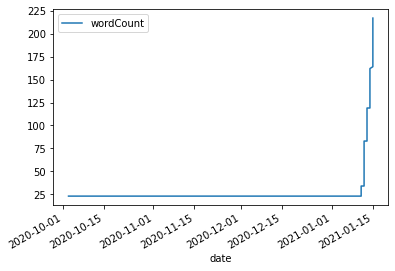

In [17]:
#Affichage du résultat pour Reddit
dfReddit.plot()

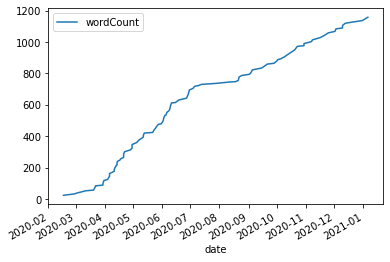

In [18]:
#Affichage du résultat pour Arvix
dfArxiv.plot()

# PARTIE 2

## Fonctions Interface

In [19]:
#Fonction d'analyse
def EvolutionTemporelle(self, entryKeyword, f, canvas):
    try:
        #Création splash
        splash = SplashAnalyse(self)
        
        #Count suivant keyword
        keyword  = entryKeyword.get().lower()

        dates = []
        wordCount = []

        for doc in corpusReddit:
            dates.append(doc.date)
            wordCount.append(doc.text.count(keyword))

        dfReddit = pd.DataFrame({'date': dates,'wordCount': wordCount}).set_index('date', drop=True)
        dfReddit.index = pd.to_datetime(dfReddit.index)
        dfReddit = dfReddit.cumsum()




        dates = []
        wordCount = []

        for doc in corpusArxiv:
            dates.append(doc.date)
            wordCount.append(doc.text.count(keyword))

        dfArxiv = pd.DataFrame({'date': dates,'wordCount': wordCount}).set_index('date', drop=True)
        dfArxiv.index = pd.to_datetime(dfArxiv.index)
        dfArxiv = dfArxiv.cumsum()

        #Affichage de la courbe
        f.clear() 
        
        a = f.add_subplot(111)
        a.plot(dfReddit, label="REDDIT")
        a.plot(dfArxiv, label="ARXIV")
        a.set_title("Analyse pour " + str(keyword))
        a.set_xlabel("Date")
        a.set_ylabel("Nombre d'apparitions")
        a.legend()
        
        canvas.draw()
        
        
        #Destruction à la fin de l'analyse
        splash.destroy()
        
    #Exception si le keyword est introuvable   
    except IndexError as error:
        splash.destroy()
        splash = SplashError(self)
    except ValueError as error:
        splash.destroy()
        splash = SplashError(self)
'''

In [22]:
#pas fini
'''
def MesureTFxIDF(self, f, canvas):
    try:
        splash = SplashAnalyse(self)
        f.clear() 
        canvas.draw()
        splash.destroy()
'''

'\ndef MesureTFxIDF(self, f, canvas):\n    try:\n        splash = SplashAnalyse(self)\n        f.clear() \n        canvas.draw()\n        splash.destroy()\n'

In [21]:
#pas fini
'''
def Summarize(self, f, canvas):
    try:
        splash = SplashAnalyse(self)
        f.clear() 
        canvas.draw()
        splash.destroy()
'''

'\ndef Summarize(self, f, canvas):\n    try:\n        splash = SplashAnalyse(self)\n        f.clear() \n        canvas.draw()\n        splash.destroy()\n'

## Interface

In [23]:
#Police et taille
LARGE_FONT= ("Arial", 20)


#Classe principale
class InterfaceGraphique(tk.Tk):

    def __init__(self, *args, **kwargs):
        
        tk.Tk.__init__(self, *args, **kwargs)
        container = tk.Frame(self)

        container.pack(side="top", fill="both", expand = True)

        container.grid_rowconfigure(0, weight=1)
        container.grid_columnconfigure(0, weight=1)
        
        self.title("Projet Python")
        self.geometry("1000x800")

        self.frames = {}

        for F in (PageEvolutionTemporelle, PageMenu):

            frame = F(container, self)

            self.frames[F] = frame

            frame.grid(row=0, column=0, sticky="nsew")

        self.show_frame(PageMenu)

    def show_frame(self, cont):

        frame = self.frames[cont]
        frame.tkraise()

#Page menu
class PageMenu(tk.Frame):

    def __init__(self, parent, controller):
        #Init
        tk.Frame.__init__(self, parent)
        
        #Label du titre dans la fenêtre
        titreMenu = tk.Label(self, text="MENU", font=LARGE_FONT)
        titreMenu.pack(pady=10,padx=10)

        #Boutons
        buttonM1 = tk.Button(self, text="Evolution temporelle du mot", relief = tk.GROOVE, command=lambda: controller.show_frame(PageEvolutionTemporelle))
        buttonM1.pack(pady = 5)

        #je n'ai pas eu le temps de finir cette partie de l'interface
        buttonM2 = tk.Button(self, text="Mesure TFxIDF", relief = tk.GROOVE)
        buttonM2.pack(pady = 5)
        
        #je n'ai pas eu le temps de finir cette partie de l'interface
        buttonM3 = tk.Button(self, text="Summarize", relief = tk.GROOVE)
        buttonM3.pack(pady = 5)

#Page supportant l'évolution temporelle         
class PageEvolutionTemporelle(tk.Frame):

    def __init__(self, parent, controller):
        #Init
        tk.Frame.__init__(self,parent)
        
        #Label du titre dans la fenêtre
        titreMethode = tk.Label(self, text = "Evolution temporelle d'un mot", font = LARGE_FONT)
        titreMethode.pack(pady = 5)

        #Champ de saisie
        champKeyword = tk.StringVar()
        entryKeyword = tk.Entry(self, textvariable = champKeyword, width = 10)
        entryKeyword.pack(pady = 5)
    
        #Boutons
        boutonValidation = tk.Button(self, text = "Valider", relief = tk.GROOVE, command = lambda: EvolutionTemporelle(self, entryKeyword, f, canvas))
        boutonValidation.pack(pady = 5)
        
        buttonMenu = tk.Button(self, text="MENU", relief = tk.GROOVE, command=lambda: controller.show_frame(PageMenu))
        buttonMenu.pack(pady = 5)

        #Figure contenant la courbe
        f = Figure(figsize=(20,15), dpi=100)
        canvas = FigureCanvasTkAgg(f, self)
        canvas.get_tk_widget().pack(side=tk.BOTTOM, fill=tk.BOTH, expand=1)

  

        
#Fenêtre affichant le chargement de l'analyse
class SplashAnalyse(tk.Toplevel):
    def __init__(self, parent):
        tk.Toplevel.__init__(self, parent)
        
        #Label du titre dans la fenêtre
        txt = tk.Label(self, text="Analyse en cours...", font=LARGE_FONT)
        txt.pack(pady=10,padx=10)

        self.update()

#Fenêtre affichant une erreur de keyword
class SplashError(tk.Toplevel):
    def __init__(self, parent):
        tk.Toplevel.__init__(self, parent)
        #Label du titre dans la fenêtre
        txt = tk.Label(self, text="Mot inexistant !", font=LARGE_FONT)
        txt.pack(pady=10,padx=10)
        
        #Boutons
        button = tk.Button(self, text="OK", relief = tk.GROOVE, command=self.destroy)
        button.pack(pady = 5)
        
        self.update()


In [ ]:
#Main
app = InterfaceGraphique()
app.mainloop()